<a href="https://colab.research.google.com/github/Lrab/COMP562_Final/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import math

In [0]:
# Importing Players.csv and Seasons_Stats.csv
Players_file = pd.read_csv('/content/gdrive/My Drive/COMP562_Final/Players.csv',sep=',',header=0)
Players = Players_file.values

Stats_file = pd.read_csv('/content/gdrive/My Drive/COMP562_Final/Seasons_Stats.csv',sep=',',header=0)
Stats = Stats_file.values

In [0]:
# Importing MVP_Winners.csv and reformatting to match earlier files
Winners_file = pd.read_csv('/content/gdrive/My Drive/COMP562_Final/MVP_Winners.csv',sep=',',header=1) #dont have data for 2017-18
Winners = Winners_file.values

for i in range(len(Winners[:,0])):
    Winners[i,0] = int(Winners[i,0][:2]+Winners[i,0][5:7])
    Winners[i,1] = Winners[i,1].split('\\')[0]
Winners[17,0] = 2000

In [0]:
# Make new arrays for MVPs, index of MVPs, and nonMVPs
MVPs = np.ndarray( (len(Winners[:,0]) , len(Stats[0,:])) , dtype='object')
MVP_index = []
nonMVPs = np.ndarray( (len(Stats[:,0])-len(Winners[:,0]) , len(Stats[0,:])) , dtype='object')
for i in range(len(Stats[:,1])):
    for j in range(len(Winners[:,0])):
        if Winners[j,0] == Stats[i,1]:
            if Winners[j,1] == Stats[i,2].strip('*'):
                MVP_index.append(i)
                MVPs[j,:] = Stats[i,:]

In [0]:
# Importing Team_Wins.csv
with open('/content/gdrive/My Drive/COMP562_Final/Team_Wins.csv') as file:
    dr = csv.DictReader(file)
    win_data = [[0,i['ATL'],i['BOS'],i['BRK'],i['CHI'],i['CHO'],i['CLE'],
                 i['DAL'],i['DEN'],i['DET'],i['GSW'],i['HOU'],i['IND'],
                 i['LAC'],i['LAL'],i['MEM'],i['MIA'],i['MIL'],i['MIN'],
                 i['NOP'],i['NYK'],i['OKC'],i['ORL'],i['PHI'],i['PHO'],
                 i['POR'],i['SAC'],i['SAS'],i['TOR'],i['UTA'],i['WAS']] for i in dr]
for i in range(len(win_data)):
    win_data[i][0] = 2017-i

In [0]:
# Stats to use for learning:
# Age, Games(/SeasonLength), Games Started(/Games), Minutes Played, TS%, 3PAr,
# FTr, ORB%, DRB%, TRB%, AST%, STL%, BLK%, TOV%, Field Goals, FGA, FG%, 3P, 3PA
# 3P%, 2P, 2PA, 2P%, eFG%, FT, FTA, FT%, ORB, DRB, TRB, AST, STL, BLK, TOV, PF,
# PTS, Team Wins, index

# Going to append id to end of each player data

# https://datascience.stackexchange.com/questions/13178/how-to-normalize-data-for-neural-network-and-decision-forest

# This puts all the raw data into a list of tuples (team wins added later)
with open('/content/gdrive/My Drive/COMP562_Final/Seasons_Stats.csv') as file:
    dr = csv.DictReader(file)
    raw_data = [(i['Year'],i['Tm'],i['Age'],i['G'],i['GS'],i['MP'],i['TS%'],i['3PAr'],
                 i['FTr'],i['ORB%'],i['DRB%'],i['TRB%'],i['AST%'],i['STL%'],i['BLK%'],
                 i['TOV%'],i['FG'],i['FGA'],i['FG%'],i['3P'],i['3PA'],i['3P%'],i['2P'],
                 i['2PA'],i['2P%'],i['eFG%'],i['FT'],i['FTA'],i['FT%'],i['ORB'],
                 i['DRB'],i['TRB'],i['AST'],i['STL'],i['BLK'],i['TOV'],i['PF'],i['PTS'],0,i['']) for i in dr]
    
# Loops to fill data into numpy array, and add team wins
for i in range(len(raw_data)):
    if raw_data[i][0] != '' and int(raw_data[i][0]) == 1974:
        start = i
        break

data = np.ndarray((len(raw_data)-start,len(raw_data[0])-2))
Wins_file = pd.read_csv('/content/gdrive/My Drive/COMP562_Final/Team_Wins.csv',sep=',',header=-1)
headers = Wins_file.values[0][3:]

for i in range(len(data)):
    # Teams with name changes
    raw_data[start+i] = list(raw_data[start+i])
    if raw_data[start+i][1] == 'KCO' or raw_data[start+i][1] == 'KCK':
        raw_data[start+i][1] = 'SAC'
    if raw_data[start+i][1] == 'SEA':
        raw_data[start+i][1] = 'OKC'
    if raw_data[start+i][1] == 'BUF' or raw_data[start+i][1] == 'SDC':
        raw_data[start+i][1] = 'LAC'
    if raw_data[start+i][1] == 'CAP' or raw_data[start+i][1] == 'WSB':
        raw_data[start+i][1] = 'WAS'
    if raw_data[start+i][1] == 'NOJ':
        raw_data[start+i][1] = 'UTA'
    if raw_data[start+i][1] == 'NYN' or raw_data[start+i][1] == 'NJN':
        raw_data[start+i][1] = 'BRK'
    if raw_data[start+i][1] == 'CHH' or raw_data[start+i][1] == 'CHA':
        raw_data[start+i][1] = 'CHO'
    if raw_data[start+i][1] == 'VAN':
        raw_data[start+i][1] = 'MEM'
    if raw_data[start+i][1] == 'NOH' or raw_data[start+i][1] == 'NOK':
        raw_data[start+i][1] = 'NOP'
    
    # Just copying over data
    for j in range(2,len(data[0])+2):
        if raw_data[start+i][j] == '':
            data[i][j-2] = 0
        else:
            data[i][j-2] = float(raw_data[start+i][j])
            if (j-2==1 or j-2==2 or j-2==3 or j-2==14 or j-2==15 or
                j-2==17 or j-2==18 or j-2==20 or j-2==21 or j-2==24 or
                j-2==25 or j-2==27 or j-2==28 or j-2==29 or j-2==30 or
                j-2==31 or j-2==32 or j-2==33 or j-2==34 or j-2==35):
                if raw_data[start+i][0] == '1999':
                    data[i][j-2] = data[i][j-2] / 50.
                elif raw_data[start+i][0] == '2012':
                    data[i][j-2] = data[i][j-2] / 66.
                else:
                    data[i][j-2] = data[i][j-2] / 82.
    
    # Adding team wins (set traded players to 0 wins)
    for k in range(len(win_data)):
        if raw_data[start+i][0] != '' and win_data[k][0] == int(raw_data[start+i][0]):
            team = raw_data[start+i][1]
            try:
                team_index = np.where(headers==team)[0][0]
                wins = 0
                if win_data[k][team_index+1] != '':
                    wins = int(win_data[k][team_index+1])
                data[i][-2] = wins
            except:
                data[i][-2] = 0
    if raw_data[start+i][0] == '1999':
        data[i][-2] = data[i][-2] / 50.
        if data[i][-2] == 0:
            data[i][-2] = 0.5
    elif raw_data[start+i][0] == '2012':
        data[i][-2] = data[i][-2] / 66.
        if data[i][-2] == 0:
            data[i][-2] = 0.5
    else:
        data[i][-2] = data[i][-2] / 82.
        if data[i][-2] == 0:
            data[i][-2] = 0.5

In [0]:
# Normalizing data and filtering for minimum minutes (oof this is ugly)
def normalize(data):
    minTime = 10.0
    low_minutes = []
    for i in range(len(data)):
        if data[i][3] < minTime:
            low_minutes.append(i)
    ndata = np.ndarray( ( len(data)-len(low_minutes), len(data[0])))

    j=0
    for i in range(len(data)):
        if i not in low_minutes:
            ndata[j] = data[i]
            j = j+1

    for i in range(len(ndata[0])-1):
        up = max(ndata[:,i])
        lo = min(ndata[:,i])
        ndata[:,i] = (ndata[:,i]-lo)/(up-lo) - 0.5
    return ndata
ndata = normalize(data)

In [0]:
#separting MVPs and adding labels
nind = []
labels = np.zeros(len(ndata))
for i in MVP_index:
    if i > 3625:
        nind.append(i)
ndata_MVP = np.ndarray((len(nind),len(ndata[0])))
for i in range(len(nind)):
    for j in range(len(ndata)):
        if nind[i] == ndata[j][-1]:
            ndata_MVP[i] = ndata[j]
            labels[j] = 1

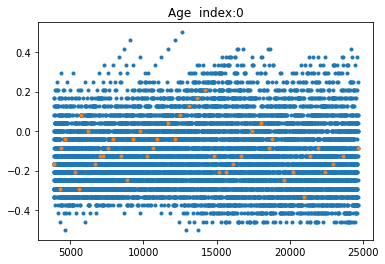

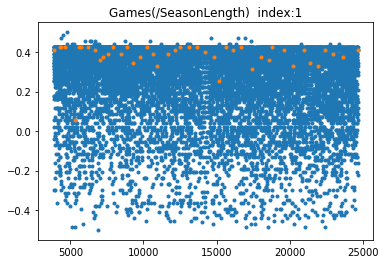

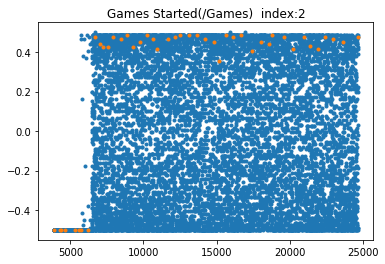

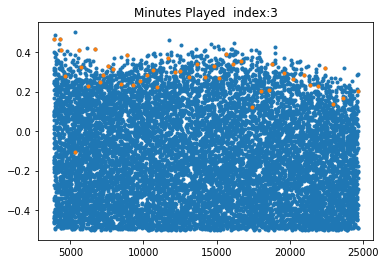

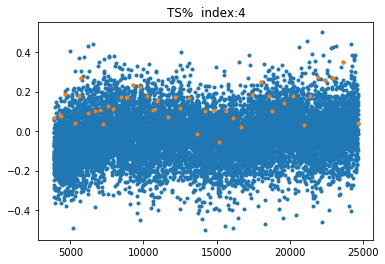

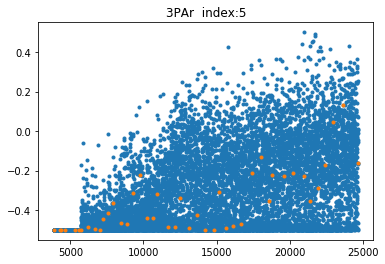

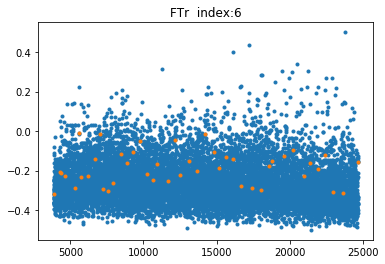

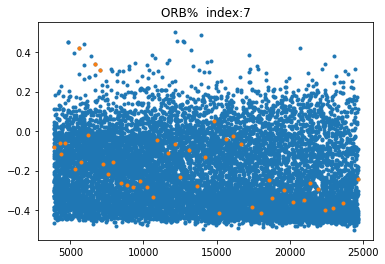

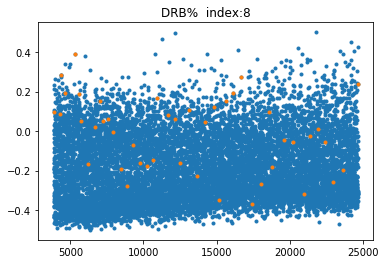

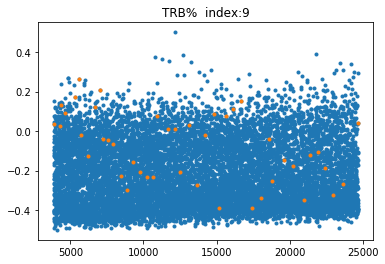

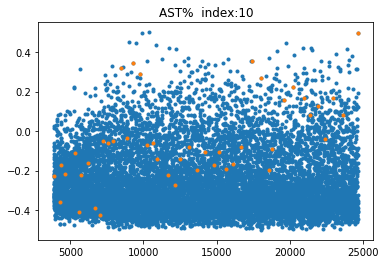

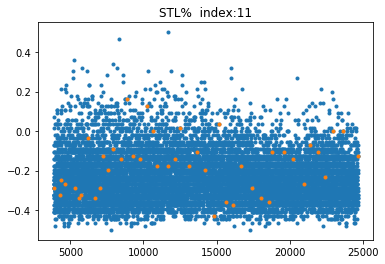

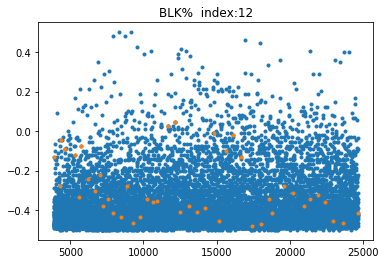

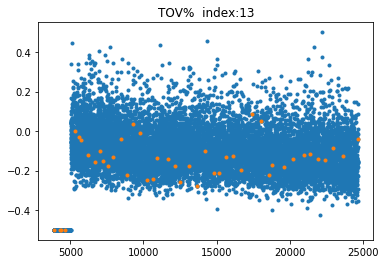

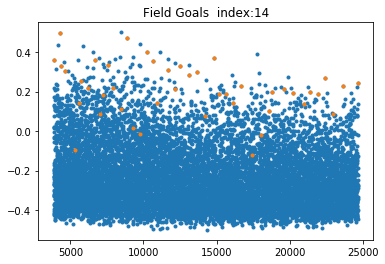

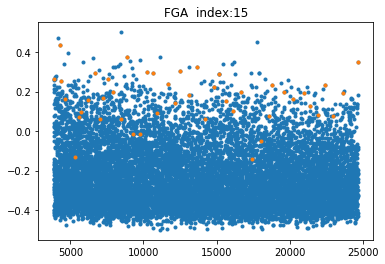

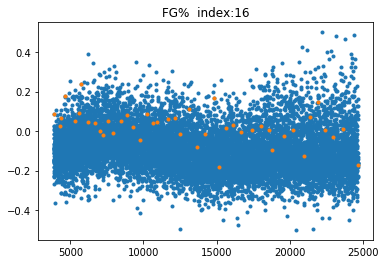

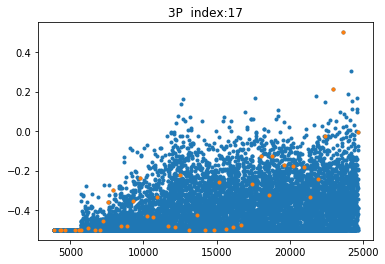

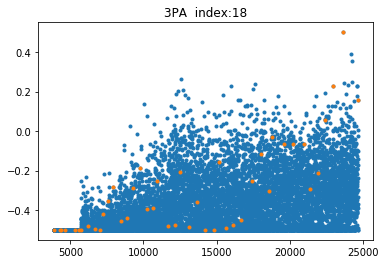

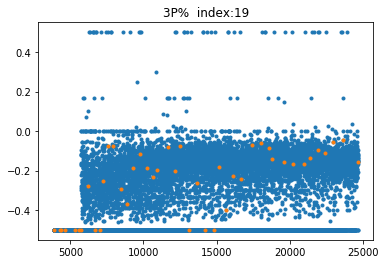

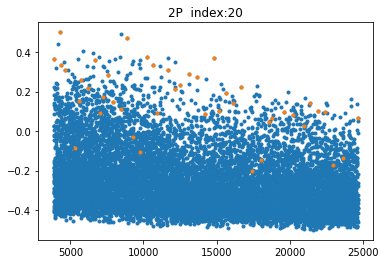

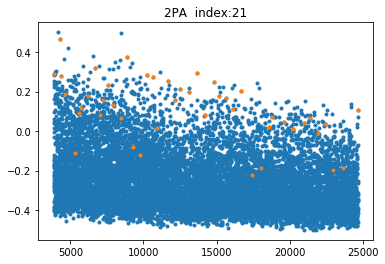

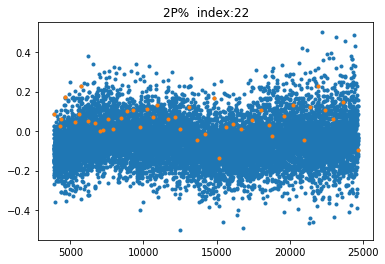

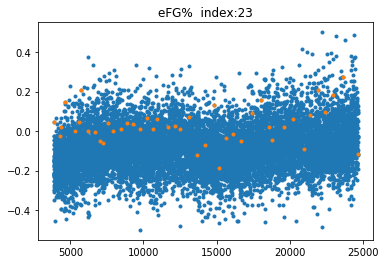

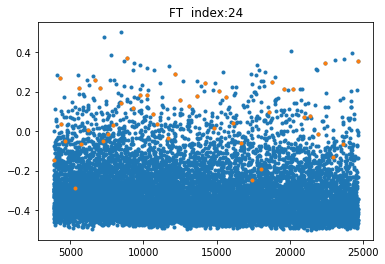

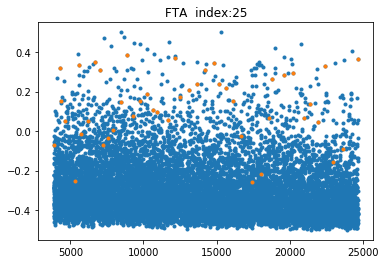

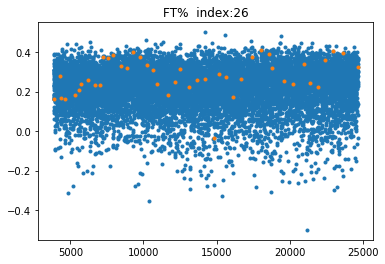

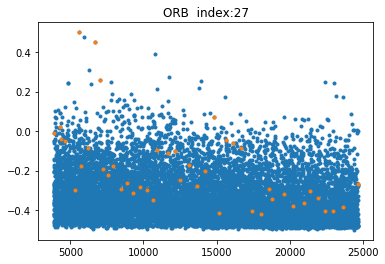

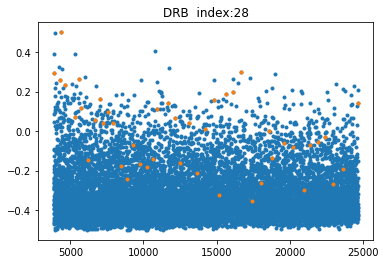

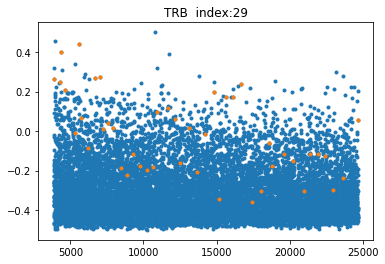

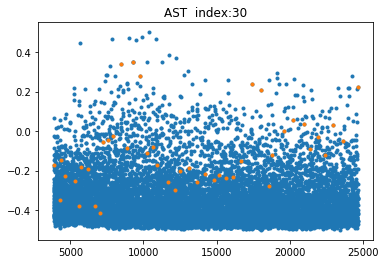

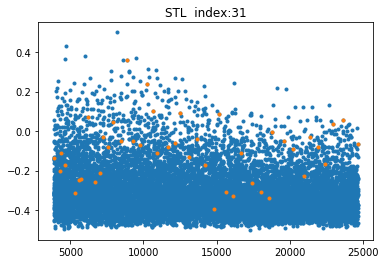

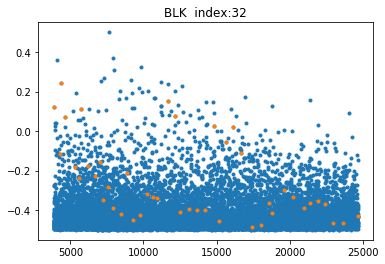

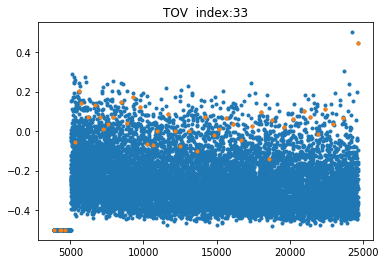

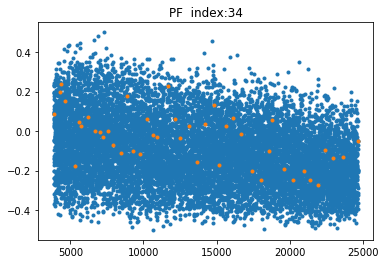

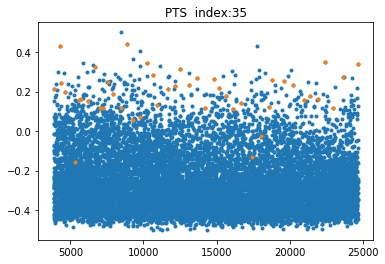

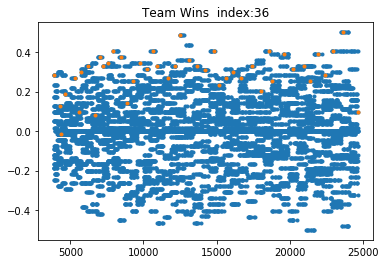

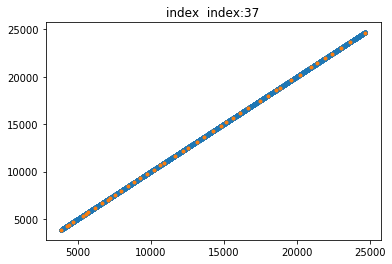

In [12]:
# Plot each column to check for outliers
Labels = [ 'Age', 'Games(/SeasonLength)', 'Games Started(/Games)', 'Minutes Played', 'TS%', '3PAr',
 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'Field Goals', 'FGA', 'FG%', '3P', '3PA',
 '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
 'PTS', 'Team Wins', 'index' ]

def feature_plots(data1, data2, Labels):
    for i in range(len(ndata[0])):
        plt.plot(data1[:,-1],data1[:,i],'.')
        plt.plot(data2[:,-1],data2[:,i],'.')
        plt.title(Labels[i]+'  index:'+str(i))
        plt.show()
feature_plots(ndata,ndata_MVP,Labels)

In [0]:
# Building MVP distance matrix
def dist(a, b):
    s = 0
    for i in range(len(a)):
        s = s + (a[i] - b[i])**2
    return np.sqrt(s)

l = len(ndata_MVP)
dist_MVP = np.ndarray((l,l))
for i in range(l):
    for j in range(l):
        dist_MVP[i][j] = dist(ndata_MVP[i][:-1], ndata_MVP[j][:-1])

In [0]:
# Finding nearest neighbors (ct is how many neighbors)
ct = 5
closest = np.zeros((l,ct)) + 10
close_dist = np.zeros((l,ct)) + 10
for i in range(l):
    for j in range(l):
        if i != j:
            if dist_MVP[i][j] < np.max(close_dist[i]):
                closest[i][np.argmax(close_dist[i])] = j
                close_dist[i][np.argmax(close_dist[i])] = dist_MVP[i][j]

In [0]:
# Code for generating printable list of closest MVPs
for i in range(l):
    mID = int(ndata_MVP[i][-1])
    year = raw_data[mID][0]
    name = Stats[mID][2]
    close = []
    for j in range(ct):
        close.append((Stats[int(ndata_MVP[int(closest[i][j])][-1])][2],
                      int(Stats[int(ndata_MVP[int(closest[i][j])][-1])][1])))
    #print(close)

In [0]:
# Generate N synthetic MVPs
N = 500
def MVP_gen(N):
    sdata_MVP = np.ndarray((N,len(ndata_MVP[0])))
    c1 = np.random.randint(0,l,N)
    c2 = np.random.randint(0,ct,N)
    for i in range(N):
        data1 = ndata_MVP[c1[i]]
        data2 = ndata_MVP[int(closest[c1[i],c2[i]])]
        sdata_MVP[i][:] = np.random.rand()*(data1-data2) + data2
    return sdata_MVP
sdata_MVP = MVP_gen(N)

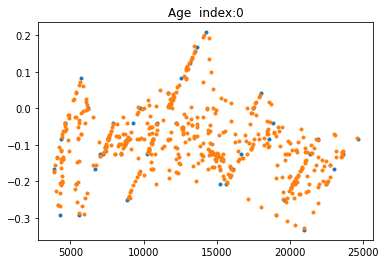

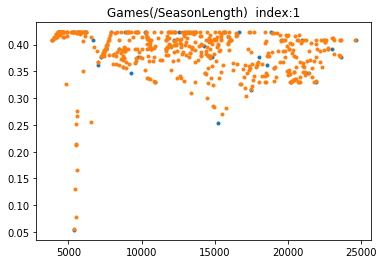

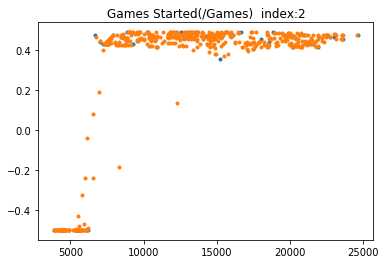

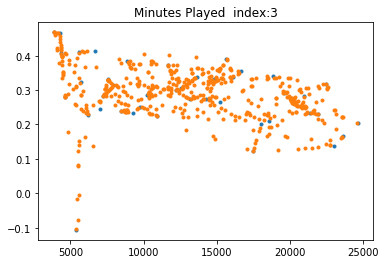

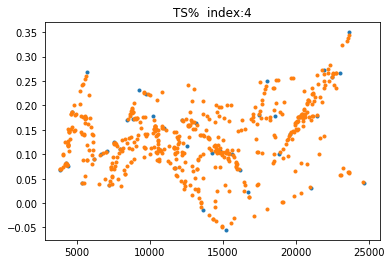

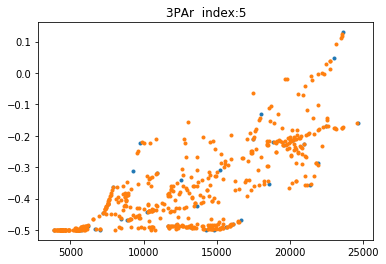

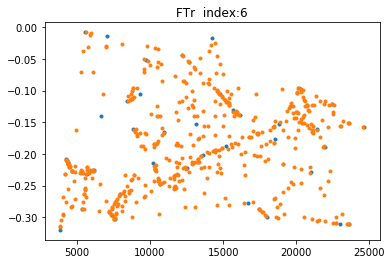

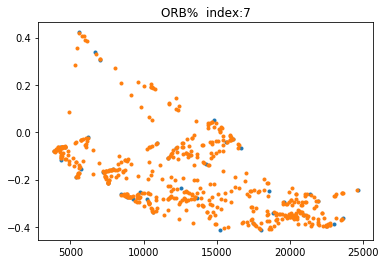

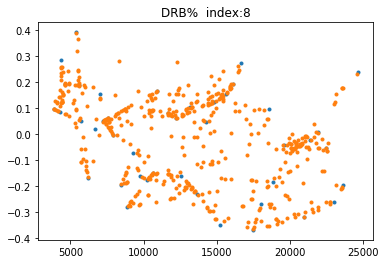

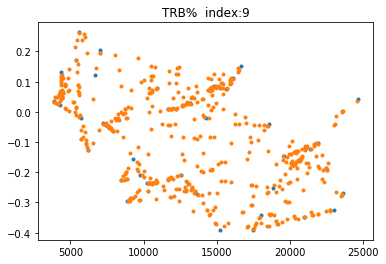

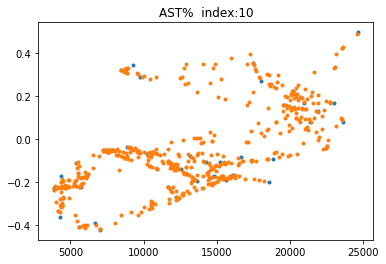

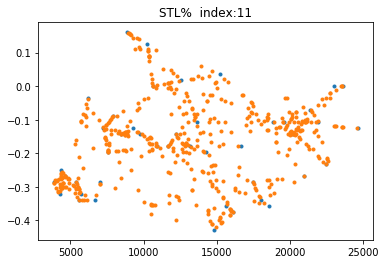

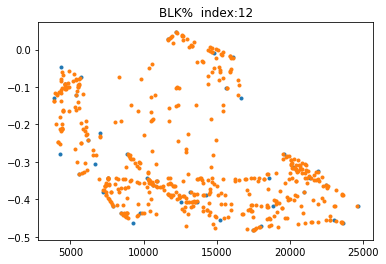

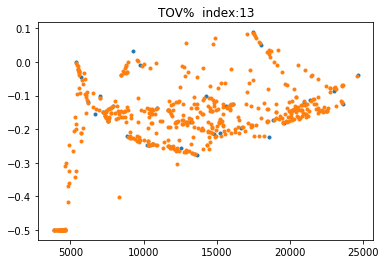

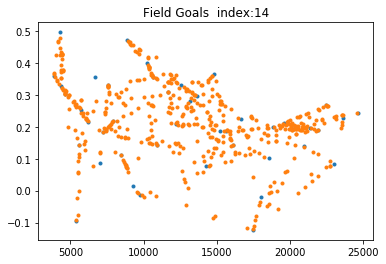

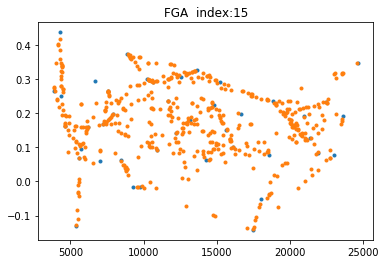

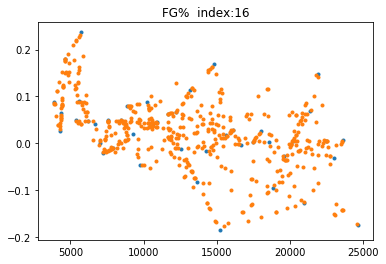

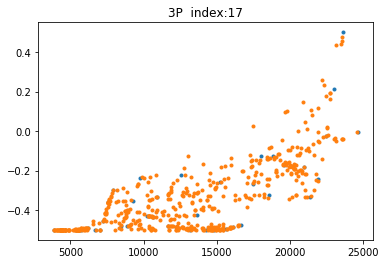

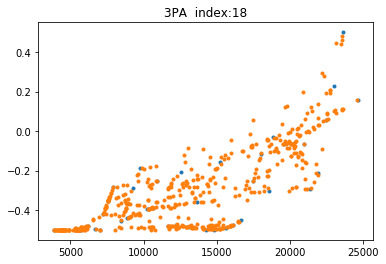

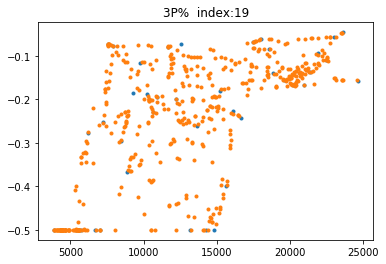

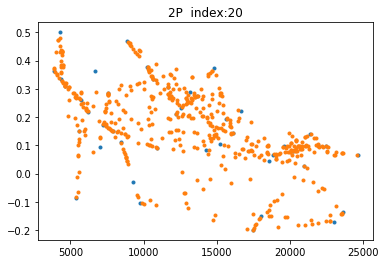

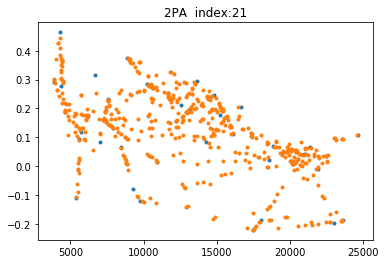

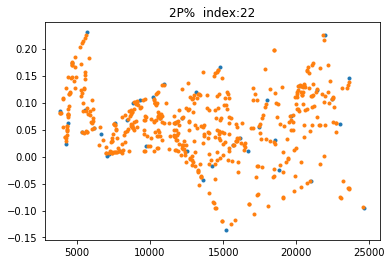

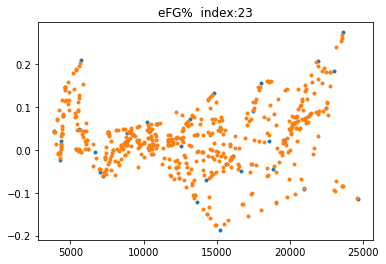

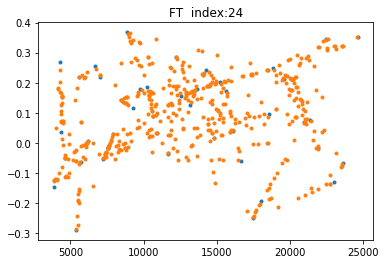

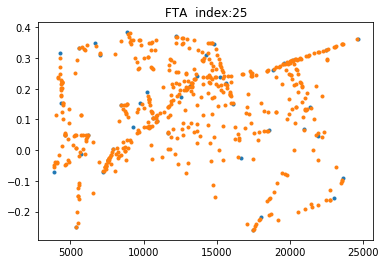

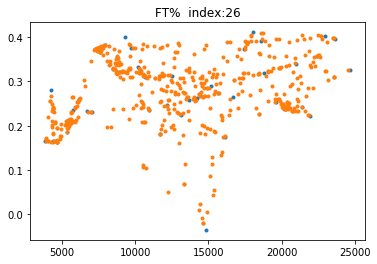

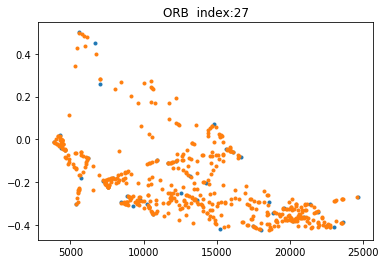

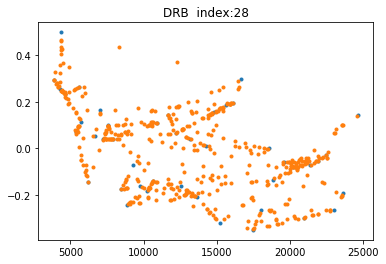

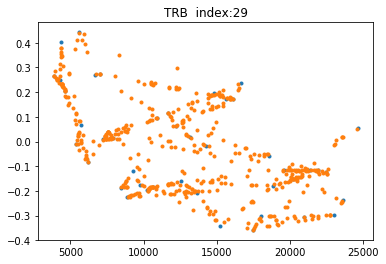

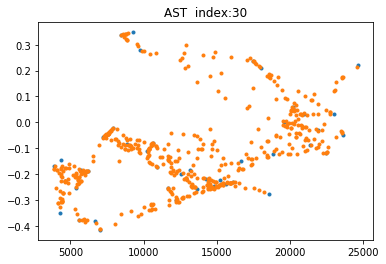

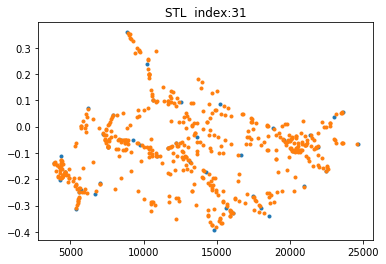

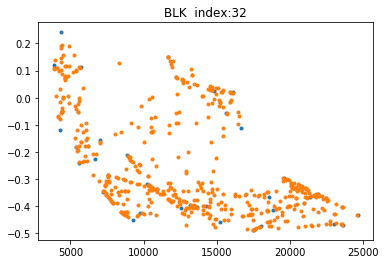

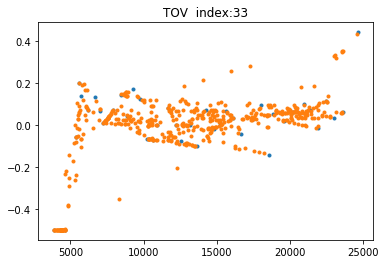

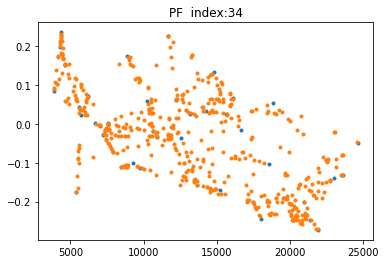

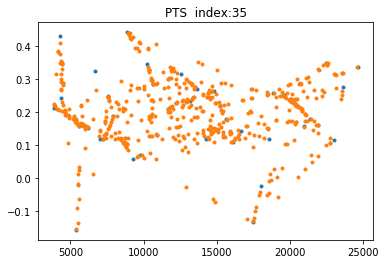

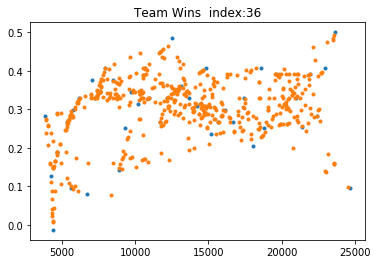

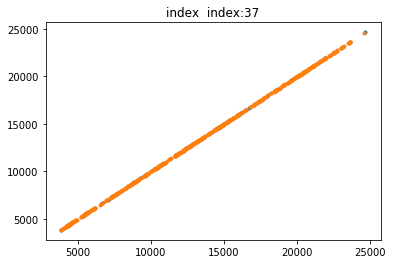

In [17]:
# Plot each column to check for outliers
feature_plots(ndata_MVP,sdata_MVP,Labels)

In [0]:
import sklearn
from sklearn.linear_model import LogisticRegression

In [19]:
# Training Logistic Regression
fit_percentage = 0.3
training_index = np.random.choice(len(ndata),size=int(fit_percentage*len(ndata)),replace=0)

clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='ovr').fit(ndata[training_index,:-1], labels[training_index])

pred = clf.predict(ndata[:,:-1])

prob = clf.predict_proba(ndata[:,:-1])

score = clf.score(ndata[:,:-1],labels)

print('Score:',score)

Score: 0.9963562409965258


In [20]:
# Finding what was right and what was wrong
pos = np.where(pred==1)[0]
MVP = np.where(labels==1)[0]

correct = np.intersect1d(pos,MVP)
fpos = np.setdiff1d(pos,correct)
fneg = np.setdiff1d(MVP,correct)

print('Correct MVPs: ',len(correct),'/',len(MVP))

Correct MVPs:  3 / 44


In [21]:
print('Correct:')
for i in range(len(correct)):
    mID = int(ndata[correct[i]][-1])
    year = raw_data[mID][0]
    name = Stats[mID][2]

    print(year,name)

Correct:
1975 Bob McAdoo*
1988 Michael Jordan*
2017 Russell Westbrook


In [22]:
print('False Positive:')
for i in range(len(fpos)):
    mID = int(ndata[fpos[i]][-1])
    year = raw_data[mID][0]
    name = Stats[mID][2]

    print(year,name)

False Positive:
1989 Michael Jordan*
1990 Michael Jordan*


In [23]:
print('False Negative:')
for i in range(len(fneg)):
    mID = int(ndata[fneg[i]][-1])
    year = raw_data[mID][0]
    name = Stats[mID][2]

    print(year,name)

False Negative:
1974 Kareem Abdul-Jabbar*
1976 Kareem Abdul-Jabbar*
1977 Kareem Abdul-Jabbar*
1978 Bill Walton*
1979 Moses Malone*
1980 Kareem Abdul-Jabbar*
1981 Julius Erving*
1982 Moses Malone*
1983 Moses Malone*
1984 Larry Bird*
1985 Larry Bird*
1986 Larry Bird*
1987 Magic Johnson*
1989 Magic Johnson*
1990 Magic Johnson*
1991 Michael Jordan*
1992 Michael Jordan*
1993 Charles Barkley*
1994 Hakeem Olajuwon*
1995 David Robinson*
1996 Michael Jordan*
1997 Karl Malone*
1998 Michael Jordan*
1999 Karl Malone*
2000 Shaquille O'Neal*
2001 Allen Iverson*
2002 Tim Duncan
2003 Tim Duncan
2004 Kevin Garnett
2005 Steve Nash
2006 Steve Nash
2007 Dirk Nowitzki
2008 Kobe Bryant
2009 LeBron James
2010 LeBron James
2011 Derrick Rose
2012 LeBron James
2013 LeBron James
2014 Kevin Durant
2015 Stephen Curry
2016 Stephen Curry


In [0]:
# Add synthetic data to dataset
slabels = np.ones(len(sdata_MVP))

cdata = np.append(ndata,sdata_MVP,axis=0)
clabels = np.append(labels,slabels)

In [25]:
# Now using logistic regression on data with synthetic MVPs included
# c = combined data, r = real data
fit_percentage = 0.3
training_index = np.random.choice(len(cdata),size=int(fit_percentage*len(cdata)),replace=0)

cclf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='ovr').fit(cdata[training_index,:-1], clabels[training_index])

cpred = cclf.predict(cdata[:,:-1])
rpred = cclf.predict(ndata[:,:-1])

cprob = cclf.predict_proba(cdata[:,:-1])
rprob = cclf.predict_proba(ndata[:,:-1])

cscore = cclf.score(cdata[:,:-1],clabels)
rscore = cclf.score(ndata[:,:-1],labels)

print('Combined Score:',cscore)
print('Original Score:',rscore)

Combined Score: 0.9913015202016097
Original Score: 0.9938988221337175


In [26]:
# Finding what was right and what was wrong
cpos = np.where(cpred==1)[0]
cMVP = np.where(clabels==1)[0]

rpos = np.where(rpred==1)[0]
rMVP = np.where(labels==1)[0]

ccorrect = np.intersect1d(cpos,cMVP)
cfpos = np.setdiff1d(cpos,ccorrect)
cfneg = np.setdiff1d(cMVP,ccorrect)

rcorrect = np.intersect1d(rpos,rMVP)
rfpos = np.setdiff1d(rpos,rcorrect)
rfneg = np.setdiff1d(rMVP,rcorrect)

print('Correct MVPs (combined): ',len(ccorrect),'/',len(cMVP))
print('Correct MVPs (original): ',len(rcorrect),'/',len(rMVP))
print('False Positives: ',len(rfpos))

Correct MVPs (combined):  505 / 544
Correct MVPs (original):  40 / 44
False Positives:  68


In [27]:
print('False Negative:')
for i in range(len(rfneg)):
    mID = int(ndata[rfneg[i]][-1])
    year = raw_data[mID][0]
    name = Stats[mID][2]

    print(year,name)

False Negative:
1978 Bill Walton*
2001 Allen Iverson*
2005 Steve Nash
2006 Steve Nash


In [28]:
print('False Positive:')
for i in range(len(rfpos)):
    mID = int(ndata[rfpos[i]][-1])
    year = raw_data[mID][0]
    name = Stats[mID][2]

    print(year,name)

False Positive:
1975 Rick Barry*
1976 Bob McAdoo*
1978 Bob McAdoo*
1979 Kareem Abdul-Jabbar*
1980 Julius Erving*
1981 Kareem Abdul-Jabbar*
1981 Moses Malone*
1982 Larry Bird*
1983 Larry Bird*
1987 Larry Bird*
1987 Michael Jordan*
1988 Larry Bird*
1989 Michael Jordan*
1989 Karl Malone*
1990 Charles Barkley*
1990 Larry Bird*
1990 Michael Jordan*
1990 Karl Malone*
1991 Magic Johnson*
1991 Karl Malone*
1991 David Robinson*
1992 Karl Malone*
1993 Michael Jordan*
1993 Karl Malone*
1993 Hakeem Olajuwon*
1994 Karl Malone*
1994 Shaquille O'Neal*
1994 David Robinson*
1995 Karl Malone*
1995 Shaquille O'Neal*
1996 Karl Malone*
1996 David Robinson*
1997 Grant Hill
1997 Michael Jordan*
1998 Karl Malone*
2000 Karl Malone*
2001 Shaquille O'Neal*
2003 Kobe Bryant
2003 Kevin Garnett
2003 Tracy McGrady
2003 Dirk Nowitzki
2005 Kevin Garnett
2005 Allen Iverson*
2005 LeBron James
2006 Kobe Bryant
2006 LeBron James
2006 Dirk Nowitzki
2007 Kobe Bryant
2007 LeBron James
2008 Allen Iverson*
2008 LeBron James
20

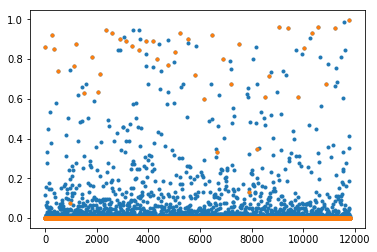

In [29]:
# Plotting MVPs by there probability and non MVPs by prob
ind = []
for i in nind:
    ind.append(i-start)

plt.plot(rprob[:,1],'.')
plt.plot(rprob[:,1]*labels,'.')
plt.show()

In [0]:
# Also find first index of each year to determine if actual MVP has higher likelihood than false positives
yearIndex = [0,]
for i in range(len(raw_data)-1):
    if raw_data[i][0] == '':
        yearIndex.append(i)
yearIndex.append(len(raw_data)+1)

data_year = []
year_groups = []
for i in range(len(yearIndex)-1):
    dy = []
    yg = []
    for j in range(len(ndata)):
        player = ndata[j]
        if player[-1] < yearIndex[i+1] and player[-1] > yearIndex[i]:
            dy.append(player)
            yg.append(j)
    data_year.append(dy)
    year_groups.append(yg)

In [31]:
# Print player most likely to win MVP each season
for i in range(len(year_groups)):
    grp = year_groups[i]
    if len(grp) > 1:
        argm = np.argmax(rprob[grp,[1]])
        n = grp[argm]

        mID = int(ndata[n][-1])
        year = raw_data[mID][0]
        name = Stats[mID][2]

        print(year,name)

1974 Kareem Abdul-Jabbar*
1975 Bob McAdoo*
1976 Kareem Abdul-Jabbar*
1977 Kareem Abdul-Jabbar*
1978 Bob McAdoo*
1979 Moses Malone*
1980 Kareem Abdul-Jabbar*
1981 Moses Malone*
1982 Moses Malone*
1983 Moses Malone*
1984 Larry Bird*
1985 Larry Bird*
1986 Larry Bird*
1987 Magic Johnson*
1988 Larry Bird*
1989 Michael Jordan*
1990 Michael Jordan*
1991 Michael Jordan*
1992 Michael Jordan*
1993 Michael Jordan*
1994 David Robinson*
1995 David Robinson*
1996 Michael Jordan*
1997 Karl Malone*
1998 Karl Malone*
1999 Karl Malone*
2000 Shaquille O'Neal*
2001 Shaquille O'Neal*
2002 Tim Duncan
2003 Kobe Bryant
2004 Kevin Garnett
2005 Allen Iverson*
2006 LeBron James
2007 Dirk Nowitzki
2008 LeBron James
2009 LeBron James
2010 LeBron James
2011 LeBron James
2012 LeBron James
2013 LeBron James
2014 Kevin Durant
2015 James Harden
2016 Stephen Curry
2017 Russell Westbrook


In [0]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn import datasets
from sklearn import svm
from joblib import load

In [33]:
# fit_percentage = 0.3
# training_index = np.random.choice(len(cdata),size=int(fit_percentage*len(cdata)),replace=0)
# my_clf = svm.SVC(C=1, kernel='poly', gamma='scale', probability=True).fit(cdata[training_index,:-1], clabels[training_index])
my_clf = load('/content/gdrive/My Drive/COMP562_Final/svm_model.joblib')
my_cpred = my_clf.predict(cdata[:,:-1])
my_rpred = my_clf.predict(ndata[:,:-1])

my_cprob = my_clf.predict_proba(cdata[:,:-1])
my_rprob = my_clf.predict_proba(ndata[:,:-1])

my_cscore = my_clf.score(cdata[:,:-1],clabels)
my_rscore = my_clf.score(ndata[:,:-1],labels)

print('Combined Score:',my_cscore)
print('Original Score:',my_rscore)

Combined Score: 0.9959352898138363
Original Score: 0.9958478095076688


In [34]:
# Finding what was right and what was wrong
my_cpos = np.where(my_cpred==1)[0]
my_cMVP = np.where(clabels==1)[0]

my_rpos = np.where(my_rpred==1)[0]
my_rMVP = np.where(labels==1)[0]

my_ccorrect = np.intersect1d(my_cpos,my_cMVP)
my_cfpos = np.setdiff1d(my_cpos,my_ccorrect)
my_cfneg = np.setdiff1d(my_cMVP,my_ccorrect)

my_rcorrect = np.intersect1d(my_rpos,my_rMVP)
my_rfpos = np.setdiff1d(my_rpos,my_rcorrect)
my_rfneg = np.setdiff1d(my_rMVP,my_rcorrect)

print('Correct MVPs (combined): ',len(my_ccorrect),'/',len(my_cMVP))
print('Correct MVPs (original): ',len(my_rcorrect),'/',len(my_rMVP))
print('False Positives: ',len(my_rfpos))

Correct MVPs (combined):  543 / 544
Correct MVPs (original):  44 / 44
False Positives:  49


In [35]:
# Find the "true score" of our logistic regression by finding the player with
# the highest likelihood to be MVP each year
ccorrect = []
counter = 0
for i in range(len(year_groups)):
    grp = year_groups[i]
    if len(grp) > 1:
        counter += 1
        argm = np.argmax(my_rprob[grp,1])
        mvp_choice = grp[argm]
        if int(ndata[mvp_choice][-1]) in MVP_index:
            ccorrect.append(i)
ctrue_score = len(ccorrect)/counter
print('True Score:',np.round(ctrue_score,5))

True Score: 0.88636


In [39]:
import torch
import torch.nn as nn
import numpy
import matplotlib.pyplot as plt
n_in, n_h, n_out, batch_size = len(cdata[0])-1, 5, 1, 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.FloatTensor(cdata[:,:-1])
y = torch.FloatTensor(clabels)
model = nn.Sequential(nn.Linear(n_in, n_h),
                     nn.ReLU(),
                     nn.Linear(n_h, n_h),
                     nn.ReLU(),
                     nn.Linear(n_h, n_h),
                     nn.ReLU(),
                     nn.Linear(n_h, n_out),
                     nn.Sigmoid())
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_list = []
for epoch in range(10000):
    x = x.to(device)
    y = y.to(device)
    # Forward Propagation
    y_pred = model(x)
    # Compute and print loss
    loss = torch.nn.functional.binary_cross_entropy(y_pred, y)
    if epoch == 0:
        print('epoch: ', 0,' loss: ', loss.item())
    #print('epoch: ', epoch,' loss: ', loss.item())
    loss_list.append(loss.item())
    # Zero the gradients
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()
print('epoch: ', epoch,' loss: ', loss.item())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size([12301])) that is different to the input size (torch.Size([12301, 1])) is deprecated. Please ensure they have the same size.


epoch:  0  loss:  0.5581422448158264
epoch:  9999  loss:  0.03873470798134804


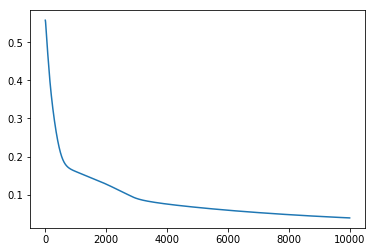

In [40]:
plt.plot(loss_list)
plt.show()